In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"

# sanity check CSV
with open(TUXML_CSV_FILENAME, "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    assert(len(t) == len(s)) # unique number of options/features/column names

# parsing for real with pandas 
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "date"] # "compile"
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


### basic stats about options and remove of unique values 
## could be improved 

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
rawtuxdata.drop(columns=ftuniques,inplace=True)

## non_tristate_options include basic stuff like date, time, cid but also string/numerical options
print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))


print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1150,6015,6026,6717,7350,7676,7726,9949,10442) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (11538, 12798)
Number of options with only one value (eg always y): (3134, 1)
Non tri-state value options (eg string or integer or hybrid values): (173, 1) 
Predictor variables: 9491


In [2]:
print("Data exploration")

Data exploration


In [3]:
#rawtuxdata[rawtuxdata['X86_64'] == 'n']
rawtuxdata.query("X86_64 == 'n'")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
6094,70713,2018-07-02 11:30:52,29.19220,1168072,466672,458720,431204,429760,420864,405663,...,n,n,n,n,n,n,n,n,n,n
6096,70715,2018-07-02 11:46:20,4.01781,-1,-1,-1,-1,-1,-1,-1,...,n,n,n,n,n,n,n,n,n,n
6097,70716,2018-07-02 11:48:23,3.17844,-1,-1,-1,-1,-1,-1,-1,...,n,n,n,n,n,n,n,n,n,n
6098,70717,2018-07-02 11:50:14,27.70240,1168072,466672,458720,431202,429760,420864,405662,...,n,n,n,n,n,n,n,n,n,n
6107,70730,2018-07-02 16:11:07,29.26880,1168072,466672,458720,431204,429808,420912,405708,...,n,n,n,n,n,n,n,n,n,n
6108,70731,2018-07-02 16:12:20,27.41670,1168072,466672,458720,431203,429792,420904,405703,...,n,n,n,n,n,n,n,n,n,n


In [4]:
#rawtuxdata[(rawtuxdata['DEBUG_INFO'] == 'n') & (rawtuxdata['GCOV_PROFILE_ALL'] == 'n') & (rawtuxdata['KASAN'] == 'n') & (rawtuxdata['MODULES'] == 'y')]
rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n') & (MODULES == 'y')")


,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
2,64512,2018-06-27 20:42:54,289.017,18772696,3296720,5383288,3154095,7339472,9425488,3078395,...,n,m,y,n,y,n,m,n,n,n
3,64513,2018-06-27 20:42:59,200.331,24147496,5141456,7226488,4993526,8967120,11051600,4702342,...,n,n,y,n,n,n,n,n,n,n
6,64516,2018-06-27 20:43:35,598.503,35061024,9131472,11216336,8982606,12568016,14652328,8303574,...,n,y,y,y,n,n,n,n,m,n
8,64518,2018-06-27 20:43:42,821.375,32526392,6546704,8635528,6314096,10765584,12853864,6416218,...,n,n,y,n,n,n,n,n,n,n
11,64521,2018-06-27 20:44:33,230.781,66906576,8507344,10594984,8309209,12971984,15059072,8656298,...,n,n,y,y,n,n,n,n,n,n
15,64525,2018-06-27 20:45:04,1623.270,89392680,19038992,21126704,18873564,21832464,23919624,17548988,...,n,y,y,y,n,n,n,n,m,y
18,64528,2018-06-27 20:45:45,507.567,20366504,3802064,5887440,3652329,7775184,9860008,3508136,...,n,n,y,y,n,n,m,n,m,n
19,64529,2018-06-27 20:46:00,216.288,13354128,3547088,5633488,3398895,7552976,9638824,3288641,...,n,n,y,y,y,n,m,m,n,n
25,64535,2018-06-27 20:46:31,311.320,19602928,3440592,5526648,3294007,7503824,9589328,3241600,...,n,n,y,n,y,n,n,n,n,n
28,64538,2018-06-27 20:47:07,453.373,19816312,5604112,7691824,5436404,9589520,11676680,5303607,...,n,n,y,n,n,n,y,n,n,n


In [5]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]
rawtuxdata.query("vmlinux == 1168072")[['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

,cid,CC_OPTIMIZE_FOR_SIZE,DEBUG_INFO_DWARF4,KASAN,UBSAN_ALIGNMENT,X86_NEED_RELOCS,RANDOMIZE_BASE,GCOV_PROFILE_ALL,UBSAN_SANITIZE_ALL,DEBUG_INFO,MODULES,DEBUG_INFO_REDUCED,DEBUG_INFO_SPLIT
6094,70713,y,n,n,n,n,n,n,n,n,n,n,n
6098,70717,y,n,n,n,n,n,n,n,n,n,n,n
6107,70730,y,n,n,n,n,n,n,n,n,n,n,n
6108,70731,y,n,n,n,n,n,n,n,n,n,n,n


In [6]:
#rawtuxdata[rawtuxdata['vmlinux'] == -1]
rawtuxdata.query("vmlinux == -1")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
9,64519,2018-06-27 20:44:05,480.489,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,y,n,y,n,n,y
17,64527,2018-06-27 20:45:35,619.328,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,y,n,n,n,y,y
38,64548,2018-06-27 20:48:15,495.525,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,y,n,n,m,n,m,y
54,64564,2018-06-27 20:50:45,246.208,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,y,n,n,n,y,n
67,64577,2018-06-27 20:52:27,377.385,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,y,n,m,n
68,64578,2018-06-27 20:52:32,255.326,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,y,n,n,n,n,n
84,64594,2018-06-27 20:54:01,396.363,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,y,n,y,n,n,n
85,64595,2018-06-27 20:54:01,257.207,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,n,y,y,y
99,64609,2018-06-27 20:57:15,296.149,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,y,n,y,n,n,n
145,64655,2018-06-27 21:03:46,192.264,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,n,n,n,n,n,n


In [7]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]['MODULES']
rawtuxdata.query("vmlinux == 1168072")['MODULES']

6094    n
6098    n
6107    n
6108    n
Name: MODULES, dtype: object

In [8]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0      30880200
1      53875520
2      18772696
3      24147496
4     230285584
5      69676088
6      35061024
7      89176752
8      32526392
9            -1
10     39675592
11     66906576
12     27363432
13     53800928
14     47768152
15     89392680
16     45488728
17           -1
18     20366504
19     13354128
Name: vmlinux, dtype: int64

In [9]:
rawtuxdata.shape, rawtuxdata[rawtuxdata['vmlinux'] != -1].shape

((11538, 9664), (10832, 9664))

In [10]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


LEARN_COMPILATION_SUCCESS = False # costly in time and space 
compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    # we can ue vmlinux since it has been restored thanks to previous line
    tuxdata_for_compilation[compilation_status_column_name] = tuxdata_for_compilation['vmlinux'] != -1
    return tuxdata_for_compilation

def learn_compilation_success(tuxdata_for_compilation):
    TESTING_SIZE=0.3 
    X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
    clf = GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))

    acc = accuracy_score (y_test, y_pred)
    prec = precision_score (y_test, y_pred)
    reca = recall_score (y_test, y_pred)
    f1 = f1_score (y_test, y_pred)
    print("Accuracy score: %.2f" % (acc))
    print("Precision score: %.2f" % (prec))
    print("Recall score: %.2f" % (reca))
    print("F1 score: %.2f" % (f1))

if (LEARN_COMPILATION_SUCCESS):
    tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
    tuxdata_for_compilation [compilation_status_column_name].describe()
    learn_compilation_success(tuxdata_for_compilation)

In [11]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
n_failures = len(rawtuxdata.query("vmlinux != -1")) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
print(str(n_failures) + " failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
#rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata.query("vmlinux != -1", inplace=True)
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")


11538 before the removal of some entries (those with same configurations)
11523 after the removal of some entries (those with same configurations)
10826 failures out of 11523
10826 after the removal of configurations that do NOT compile


In [12]:
print("some configurations have X86_32 (coz we have tested/tried some options and there are in the database)", rawtuxdata['X86_64'].describe())
# we only keep X86_64 configurations
#rawtuxdata = rawtuxdata[rawtuxdata['X86_64'] == 'y'] ### TODO: I've impression it's not the most effective way (wrt memory) to filter 
rawtuxdata.query("X86_64 == 'y'", inplace=True)
rawtuxdata.info(memory_usage='deep')


some configurations have X86_32 (coz we have tested/tried some options and there are in the database) count     10826
unique        2
top           y
freq      10825
Name: X86_64, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10825 entries, 0 to 11537
Columns: 9664 entries, cid to NETWORK_FILESYSTEMS
dtypes: float64(1), int64(153), object(9510)
memory usage: 6.3 GB


<Figure size 432x288 with 0 Axes>

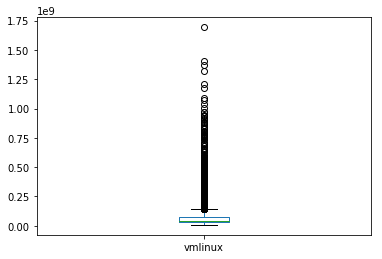

<Figure size 432x288 with 0 Axes>

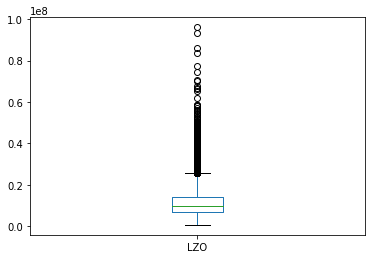

<Figure size 432x288 with 0 Axes>

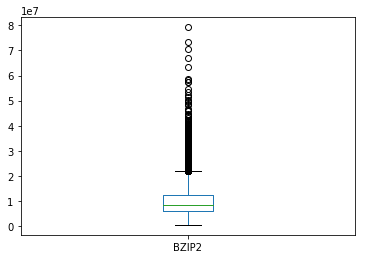

count    1.082500e+04
mean     7.141288e+07
std      9.231626e+07
min      7.317008e+06
25%      2.923890e+07
50%      4.390270e+07
75%      7.449653e+07
max      1.693674e+09
Name: vmlinux, dtype: float64

In [13]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show(block=False)


rawtuxdata['vmlinux'].describe()


In [14]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,2.90905,25.2351,39.4664,-10.3632,-16.5236
BZIP2o,-2.73825,0,21.8092,35.6065,-12.8642,-18.8741
LZMAo,-20.0748,-17.7501,0,11.3763,-28.3202,-33.2292
XZo,-27.9682,-25.8969,-9.86881,0,-35.4085,-39.833
LZOo,11.6456,14.8309,39.9029,55.7742,0,-6.90364
LZ4o,19.9909,23.3792,50.4083,67.4658,7.43577,0


In [15]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-30.6705,24.8193,38.4268,-10.0454,-16.24
BZIP2o,48.6138,0,84.879,104.671,33.7919,24.6329
LZMAo,-19.8069,-44.5819,0,10.9095,-27.8245,-32.7781
XZo,-27.4322,-49.9214,-9.5054,0,-34.6953,-39.1781
LZOo,11.2498,-22.8091,38.9453,54.0699,0,-6.91644
LZ4o,19.5798,-16.9899,49.3947,65.6516,7.44957,0


In [16]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-25.8761,19.2512,29.0256,-8.25818,-13.5075
BZIP2o,36.813,0,62.5097,75.5433,25.6834,18.5908
LZMAo,-16.0129,-37.987,0,8.1671,-22.8908,-27.2732
XZo,-22.1596,-42.615,-7.34634,0,-28.5295,-32.5863
LZOo,9.08069,-19.0365,30.1891,40.866,0,-5.75449
LZ4o,15.8083,-13.9698,38.2848,49.6344,6.12737,0


In [17]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.482777,0.482804,0.481902,0.498153,0.498078,0.49735,0.471369,0.471406,0.470158,0.475149,0.475189,0.473869,0.499336,0.499357,0.498661,0.505366,0.505384,0.504782
GZIP-bzImage,0.482777,1,1,0.99999,0.996828,0.996452,0.997013,0.997641,0.997643,0.997567,0.993868,0.993869,0.993801,0.996762,0.996757,0.996896,0.993344,0.993339,0.993519
GZIP-vmlinux,0.482804,1,1,0.99999,0.996833,0.996458,0.997018,0.99764,0.997642,0.997565,0.993867,0.993869,0.9938,0.996766,0.996762,0.9969,0.993351,0.993346,0.993526
GZIP,0.481902,0.99999,0.99999,1,0.996626,0.996251,0.996832,0.997672,0.997673,0.997624,0.993886,0.993887,0.993848,0.996585,0.99658,0.996736,0.993097,0.993091,0.993287
BZIP2-bzImage,0.498153,0.996828,0.996833,0.996626,1,0.999623,0.99999,0.993318,0.993327,0.992985,0.990869,0.990877,0.990525,0.998249,0.99825,0.998219,0.997078,0.997077,0.997105
BZIP2-vmlinux,0.498078,0.996452,0.996458,0.996251,0.999623,1,0.999613,0.992941,0.99295,0.992608,0.990455,0.990463,0.990112,0.997888,0.997888,0.997858,0.996721,0.99672,0.996749
BZIP2,0.49735,0.997013,0.997018,0.996832,0.99999,0.999613,1,0.993544,0.993552,0.993237,0.991082,0.99109,0.990768,0.998264,0.998264,0.998251,0.997021,0.997019,0.997063
LZMA-bzImage,0.471369,0.997641,0.99764,0.997672,0.993318,0.992941,0.993544,1,1,0.999982,0.994271,0.994271,0.994264,0.990382,0.990377,0.990549,0.985196,0.985189,0.985399
LZMA-vmlinux,0.471406,0.997643,0.997642,0.997673,0.993327,0.99295,0.993552,1,1,0.999981,0.994272,0.994271,0.994264,0.990391,0.990385,0.990557,0.985207,0.985201,0.985409
LZMA,0.470158,0.997567,0.997565,0.997624,0.992985,0.992608,0.993237,0.999982,0.999981,1,0.994237,0.994235,0.994267,0.990082,0.990076,0.990271,0.984799,0.984792,0.985023


In [18]:
#from category_encoders import *
from sklearn.preprocessing import *

## class to integer encoding (y, n, m)

## note: we also remove non-tristate-options
# "in place" is to avoid memory burden (having two dfs in memory)

# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
rawtuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
rawtuxdata[size_methods] = vml
 
rawtuxdata.shape, rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10825 entries, 0 to 11537
Columns: 9491 entries, X86_LOCAL_APIC to LZ4
dtypes: int64(9491)
memory usage: 783.9 MB


((10825, 9491), None)

In [19]:
#### takes a while
# One-Hot-Encoding 
#from sklearn.preprocessing import *

#enc = OneHotEncoder()
#o_sizes = rawtuxdata[size_methods]
#oh_tuxdata = enc.fit_transform(rawtuxdata)
#oh_tuxdata.shape, o_sizes.shape
# rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(enc.fit_transform)
#oh_tuxdata[size_methods] = o_sizes

In [20]:
# DUMMY (with Pandas)

#o_sizes = tuxdata[size_methods]
#tuxdata_dummy = pd.get_dummies(rawtuxdata.drop(columns=size_methods), columns=rawtuxdata.drop(columns=size_methods).columns)
#tuxdata_dummy[size_methods] = o_sizes
#tuxdata_dummy.shape

In [21]:
# Data exploration (again)
print(rawtuxdata['UBSAN_SANITIZE_ALL'].value_counts(), rawtuxdata['COMPILE_TEST'].value_counts(), rawtuxdata['NOHIGHMEM'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts(), rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), sep='\n')

0    9511
1    1314
Name: UBSAN_SANITIZE_ALL, dtype: int64
1    5420
0    5405
Name: COMPILE_TEST, dtype: int64
0    10825
Name: NOHIGHMEM, dtype: int64
1    5595
0    5230
Name: OPTIMIZE_INLINING, dtype: int64
0    10523
1      302
Name: SLOB, dtype: int64
0    10420
1      405
Name: CC_OPTIMIZE_FOR_SIZE, dtype: int64


In [22]:
from enum import Enum
class LearningStrategy(Enum):
    LINEAR = 1
    AUTOML = 2
    ML = 3

In [23]:
from sklearn.pipeline import Pipeline

# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPRegressor





# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)


def prefilter_data(tuxdata):
    NO_ENCODED_VALUE = le.transform(['n'])[0] 
    return tuxdata.query("DEBUG_INFO == " + str(NO_ENCODED_VALUE))

def regLearning(tuxdata, kindOfLearning=LearningStrategy.ML):
 
    TESTING_SIZE=0.9 # 0.9 means 10% for training, 90% for testing
    size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 
    PRINT_FEATURE_IMPORTANCES = False
   
       
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])].drop(columns=size_methods), tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])][size_of_interest], test_size=TESTING_SIZE, random_state=0)  
    print ("Warning: focus on DEBUG_INFO=n")   
    X_train, X_test, y_train, y_test = train_test_split(prefilter_data(tuxdata).drop(columns=size_methods), prefilter_data(tuxdata)[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
  
    # multi output
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

    # train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

    #clf = RandomForestRegressor(n_estimators=100) 

    if kindOfLearning == LearningStrategy.LINEAR:
        regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

    elif kindOfLearning == LearningStrategy.AUTOML:


        tpot_config = {

            'sklearn.linear_model.ElasticNetCV': {
                'l1_ratio': np.arange(0.0, 1.01, 0.05),
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
            },

            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.ensemble.GradientBoostingRegressor': {
                'n_estimators': [100],
                'loss': ["ls", "lad", "huber", "quantile"],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'subsample': np.arange(0.05, 1.01, 0.05),
                'max_features': np.arange(0.05, 1.01, 0.05),
                'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
            },

            'sklearn.ensemble.AdaBoostRegressor': {
                'n_estimators': [100],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'loss': ["linear", "square", "exponential"],
                'max_depth': range(1, 11)
            },

            'sklearn.tree.DecisionTreeRegressor': {
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21)
            },

            'sklearn.neighbors.KNeighborsRegressor': {
                'n_neighbors': range(1, 101),
                'weights': ["uniform", "distance"],
                'p': [1, 2]
            },

            'sklearn.linear_model.LassoLarsCV': {
                'normalize': [True, False]
            },

            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            },

            'sklearn.ensemble.RandomForestRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.linear_model.RidgeCV': {
            },

            'xgboost.XGBRegressor': {
                'n_estimators': [100],
                'max_depth': range(1, 11),
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'subsample': np.arange(0.05, 1.01, 0.05),
                'min_child_weight': range(1, 21),
                'nthread': [1]
            }     
        }

        tpot = TPOTRegressor(generations=5, population_size=50, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot.fit(X_train, y_train)
        y_pred = tpot.predict(X_test)
        print(tpot.score(X_test, y_test))
        print(tpot.evaluated_individuals_)
        tpot.export('tpot_boston_pipeline.py')

    else:
        assert (kindOfLearning == LearningStrategy.ML)
        clf = GradientBoostingRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) #GradientBoostingRegressor(n_estimators=100) # KNeighborsRegressor() #RandomForestRegressor(n_estimators=100) # linear_model.SGDRegressor(alpha=0.15, max_iter=200)
        # #LassoLarsCV() # MLPRegressor() # GradientBoostingRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #  #   GradientBoostingRegressor(n_estimators=100) # 
        # 
        #estimator = RandomForestRegressor(n_estimators=100) # RidgeCV(alphas=[1000.0]) # LassoCV(tol = 0.001) #   #  # RandomForestRegressor(n_estimators=100) #LassoCV() #RidgeCV(alphas=[2000.0]) # LassoCV()
        #clf = PipelineRFE([ # Pipeline([
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = PipelineRFE([
          #('reduce_dim', PCA()),
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        #    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100)),
        #    KNeighborsRegressor(n_neighbors=82, p=2, weights="distance")
        #)


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure()
    #plt.title("Feature importances for size of vmlinux")
    #plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
    #plt.xticks(range(tuxdata.shape[1]), indices)
    #plt.xlim([-1, tuxdata.shape[1]])
    #plt.show()
    mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
    mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
    r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 

    ONE_MEGABYTE = 1048576

    print("Prediction score (MAE): %.2f" % (mae / ONE_MEGABYTE))
    print("Prediction score (MSE): %.2f" % (mse / ONE_MEGABYTE))
    print("Prediction score (R2): %.2f" % (r2))
    
regLearning(rawtuxdata)
#regLearning(tuxdata_dummy)


Prediction score (MAE): 9.04
Prediction score (MSE): 352806877.34
Prediction score (R2): 0.70


In [25]:
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel

#model = SelectFromModel(clf, prefit=True)
#tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced.shape, tuxdata.shape


In [26]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE


#alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]
#selector = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]) # LassoCV(tol = 0.001) # RidgeCV(alphas=[2000.0])  # 
#lass = selector #SelectFromModel(selector) #  RFECV(estimator=selector, step=1, scoring='neg_mean_squared_error') # 
#lass = RFE(estimator=selector, step=1)
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape  
#lass.alpha_ 



In [27]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=100)
#pca.fit(X_train, y_train)

#tuxdata_reduced_pca = pca.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_pca.shape, tuxdata.shape  

#pca.components_.shape

#plt.matshow(pca.components_, cmap='viridis')
#plt.yticks([0, 1], ["First component", "Second component"])
#plt.colorbar()
#plt.xticks(range(len(X_train.columns)),
#           X_train.columns, rotation=60, ha='left')
#plt.xlabel("Feature")
#plt.ylabel("Principal components")

In [28]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [29]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [30]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [31]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [32]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [33]:
#size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
#              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
#              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
#size_methods_without_soi

In [34]:
#import h2o
#from h2o.automl import H2OAutoML
#h2o.init()
#df = h2o.import_file(TUXML_CSV_FILENAME)

In [35]:
#df.describe()

In [36]:
#splits = df.split_frame(ratios = [0.8], seed = 1)
#train = splits[0]
#test = splits[1]

In [37]:
#y = size_of_interest
#aml = H2OAutoML(max_runtime_secs = 36000, seed = 1, project_name = "tuxlearning")
#aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [38]:
#aml.leaderboard.head()

In [39]:
#pred = aml.predict(test)
#pred.head()

In [40]:
#perf = aml.leader.model_performance(test)
#perf

In [41]:
#h2o.shutdown()

In [42]:
#import category_encoders as ce

#colmatters = list(tuxdata.columns)
#for s in size_methods:
#    colmatters.remove(s)
    
# colmatters.remove(size_methods)
#encoder = ce.OneHotEncoder(cols=colmatters) #cols=tuxdata.drop(columns=size_methods).columns

#o_sizes = tuxdata[size_methods]
#encoder.fit(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2 = encoder.transform(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2[size_methods] = o_sizes

In [43]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]#['MODULES']

In [44]:
#tuxdata_dummy2.shape, tuxdata.shape

In [45]:
#rawtuxdata[(rawtuxdata['MODULES'] == 'y')]['vmlinux'].describe(), rawtuxdata[(rawtuxdata['MODULES'] == 'n')]['vmlinux'].describe()
#rawtuxdata[(rawtuxdata['UBSAN_SANITIZE_ALL'] == 'y')]
# [['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

In [46]:
rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10825 entries, 0 to 11537
Columns: 9491 entries, X86_LOCAL_APIC to LZ4
dtypes: int64(9491)
memory usage: 783.9 MB
